# Diffusion Model

In this report, I implement a [Denoising Diffusion Probabilistic Model](https://arxiv.org/pdf/2006.11239.pdf)

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from unet import Unet
import os
import math
from matplotlib import pyplot as plt

torch.manual_seed(0)

In [2]:
def create_mnist_dataloaders(batch_size,image_size=28,num_workers=2):
    '''
        Data loading code. Do not modify.
    '''

    preprocess=transforms.Compose([transforms.Resize(image_size),\
                                    transforms.ToTensor(),\
                                    transforms.Normalize([0.5],[0.5])]) #[0,1] to [-1,1]

    train_dataset=MNIST(root="./mnist_data",\
                        train=True,\
                        download=True,\
                        transform=preprocess
                        )

    # Pick out only the first 5000 1s
    valid_idxs = []
    for idx, d in enumerate(train_dataset):
        if(d[1] in [1, 5]):
            valid_idxs.append(idx)
        if(len(valid_idxs) >= 5000):
            break

    # Create subset
    train_dataset = torch.utils.data.Subset(train_dataset, valid_idxs)

    return DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=num_workers)

## a,b,c,d) Model Implementation

In this section you will implement each part of the diffusion model. That is the model parameters, forward diffusion, reverse diffusion, and the denoising sampling procedure.
To set up the following cell, I referenced the following link as a useful resource:
https://github.com/bot66/MNISTDiffusion/blob/main


In [3]:
import torch.nn as nn
import torch
import math
from unet import Unet
from tqdm import tqdm

class MNISTDiffusion(nn.Module):
    def __init__(self,image_size,in_channels,time_embedding_dim=256,timesteps=1000,base_dim=32,dim_mults= [1, 2, 4, 8]):
        super().__init__()
        self.timesteps=timesteps
        self.in_channels=in_channels
        self.image_size=image_size

        betas=self._cosine_variance_schedule(timesteps)

        alphas=1.-betas
        alphas_cumprod=torch.cumprod(alphas,dim=-1)

        self.register_buffer("betas",betas)
        self.register_buffer("alphas",alphas)
        self.register_buffer("alphas_cumprod",alphas_cumprod)
        self.register_buffer("sqrt_alphas_cumprod",torch.sqrt(alphas_cumprod))
        self.register_buffer("sqrt_one_minus_alphas_cumprod",torch.sqrt(1.-alphas_cumprod))

        self.model=Unet(timesteps,time_embedding_dim,in_channels,in_channels,base_dim,dim_mults)

    def _cosine_variance_schedule(self,timesteps,epsilon= 0.008):
        steps=torch.linspace(0,timesteps,steps=timesteps+1,dtype=torch.float32)
        f_t=torch.cos(((steps/timesteps+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
        betas=torch.clip(1.0-f_t[1:]/f_t[:timesteps],0.0,0.999)

        return betas

    def forward(self,x,noise):
        # x:NCHW
        t=torch.randint(0,self.timesteps,(x.shape[0],)).to(x.device)
        x_t=self._forward_diffusion(x,t,noise)
        pred_noise=self.model(x_t,t)

        return pred_noise

    def _forward_diffusion(self,x_0,t,noise):

        pred_noise = self.sqrt_alphas_cumprod.gather(-1,t).reshape(x_0.shape[0],1,1,1)*x_0+ \
                self.sqrt_one_minus_alphas_cumprod.gather(-1,t).reshape(x_0.shape[0],1,1,1)*noise
        return pred_noise

    @torch.no_grad()

    def _reverse_diffusion(self,x_t,t,noise):
      #For setting up the model, below github code has been used as reference:
      #https://github.com/bot66/MNISTDiffusion/blob/main/model.py
        '''
        p(x_{t-1}|x_{t})-> mean,std

        pred_noise-> pred_mean and pred_std
        '''
        pred=self.model(x_t,t)
        alpha_t=self.alphas.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        alpha_t_cumprod=self.alphas_cumprod.gather(-1,t).reshape(x_t.shape[0],1,1,1)
        beta_t=self.betas.gather(-1,t).reshape(x_t.shape[0],1,1,1)

        x_0_pred=torch.sqrt(1. / alpha_t_cumprod)*x_t-torch.sqrt(1. / alpha_t_cumprod - 1.)*pred
        x_0_pred.clamp_(-1., 1.)

        if t.min()>0:
          alpha_t_cumprod_prev=self.alphas_cumprod.gather(-1,t-1).reshape(x_t.shape[0],1,1,1)
          mean= (beta_t * torch.sqrt(alpha_t_cumprod_prev) / (1. - alpha_t_cumprod))*x_0_pred +\
                ((1. - alpha_t_cumprod_prev) * torch.sqrt(alpha_t) / (1. - alpha_t_cumprod))*x_t

          std=torch.sqrt(beta_t*(1.-alpha_t_cumprod_prev)/(1.-alpha_t_cumprod))
        else:
            mean=(beta_t / (1. - alpha_t_cumprod))*x_0_pred #alpha_t_cumprod_prev=1 since 0!=1
            std=0.0

        return mean+std*noise

    @torch.no_grad()
    def sampling(self, n_samples, device="cuda"):
        all_samples = []
        x_t = torch.randn((n_samples, self.in_channels, self.image_size, self.image_size), device=device)

        for i in tqdm(range(self.timesteps - 1, -1, -1), desc="Sampling"):
            noise = torch.randn_like(x_t).to(device)
            t = torch.tensor([i for _ in range(n_samples)], device=device)

            x_t = self._reverse_diffusion(x_t, t, noise)

            all_samples.append(x_t.clone())

        all_samples = torch.stack(all_samples, dim=0)
        sample = (x_t + 1.) / 2.

        return sample.clone(), all_samples.clone()

## e) Model Training

Now it is time to implement your training loop. You will need to choose a learning rate, batch size, number of epochs, model dimension, and number of timesteps. You will also need to select an optimizer, scheduler, and loss function.

In [4]:
def main():
    device = "cuda" if torch.cuda.is_available() else 'cpu'

    # Model and training hyperparameters
    lr = 1e-3
    batch_size = 128
    epochs = 200
    model_base_dim = 64
    weight_decay = 1.e-5

    # Number of noising/denoising steps to take
    timesteps = 2000

    # Controls how often loss is printed and plots are generated
    log_freq = 10
    plot_freq = 10

    # For plotting. Do not modify.
    n_samples = 36

    # Get data
    train_dataloader=create_mnist_dataloaders(batch_size=batch_size,image_size=28)

    # Get model
    model=MNISTDiffusion(timesteps=timesteps,
                image_size=28,
                in_channels=1,
                base_dim=model_base_dim,
                dim_mults=[2,4]).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay )
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
    loss_fn = torch.nn.MSELoss()

    global_steps=0

    for i in range(epochs):
        model.train()

        for j, (image, target) in enumerate(train_dataloader):

            image = image.to(device)
            noise = torch.randn_like(image).to(device)
            optimizer.zero_grad()

            pred_noise = model(image, noise)

            loss = loss_fn(pred_noise, noise)

            # Backpropagation
            loss.backward()
            optimizer.step()

            # Print training progress
            global_steps += 1
            if j % log_freq == 0:
                print("Epoch[{}/{}],Step[{}/{}],loss:{:.5f},lr:{:.5f}".format(i+1,epochs,j,len(train_dataloader),
                                                                    loss.detach().cpu().item(),scheduler.get_last_lr()[0]))
        if(i%plot_freq == 0):
            ckpt={"model":model.state_dict()}
            os.makedirs("results",exist_ok=True)
            torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))
            model.eval()
            s, samples = model.sampling(n_samples,device=device)
            save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    # Final round of plots
    os.makedirs("results",exist_ok=True)
    torch.save(ckpt,"results/steps_{:0>8}.pt".format(global_steps))

    model.eval()
    s, samples=model.sampling(n_samples,device=device)

    save_image(s,"results/steps_{:0>8}.png".format(global_steps),nrow=int(math.sqrt(n_samples)))

    return s, samples

In [5]:
s, samples = main()

100%|██████████| 9912422/9912422 [00:00<00:00, 107729749.34it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 94711253.97it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30418375.33it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1204129.24it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



Epoch[1/200],Step[0/40],loss:1.16072,lr:0.00100
Epoch[1/200],Step[10/40],loss:0.78018,lr:0.00100
Epoch[1/200],Step[20/40],loss:0.57378,lr:0.00100
Epoch[1/200],Step[30/40],loss:0.43744,lr:0.00100


Sampling: 100%|██████████| 2000/2000 [00:50<00:00, 39.39it/s]


Epoch[2/200],Step[0/40],loss:0.35280,lr:0.00100
Epoch[2/200],Step[10/40],loss:0.29744,lr:0.00100
Epoch[2/200],Step[20/40],loss:0.27830,lr:0.00100
Epoch[2/200],Step[30/40],loss:0.23954,lr:0.00100
Epoch[3/200],Step[0/40],loss:0.21241,lr:0.00100
Epoch[3/200],Step[10/40],loss:0.19219,lr:0.00100
Epoch[3/200],Step[20/40],loss:0.21391,lr:0.00100
Epoch[3/200],Step[30/40],loss:0.17849,lr:0.00100
Epoch[4/200],Step[0/40],loss:0.17247,lr:0.00100
Epoch[4/200],Step[10/40],loss:0.15907,lr:0.00100
Epoch[4/200],Step[20/40],loss:0.17119,lr:0.00100
Epoch[4/200],Step[30/40],loss:0.14318,lr:0.00100
Epoch[5/200],Step[0/40],loss:0.13159,lr:0.00100
Epoch[5/200],Step[10/40],loss:0.12983,lr:0.00100
Epoch[5/200],Step[20/40],loss:0.12970,lr:0.00100
Epoch[5/200],Step[30/40],loss:0.12415,lr:0.00100
Epoch[6/200],Step[0/40],loss:0.11663,lr:0.00100
Epoch[6/200],Step[10/40],loss:0.11871,lr:0.00100
Epoch[6/200],Step[20/40],loss:0.11049,lr:0.00100
Epoch[6/200],Step[30/40],loss:0.09540,lr:0.00100
Epoch[7/200],Step[0/40],l

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 38.28it/s]


Epoch[12/200],Step[0/40],loss:0.07102,lr:0.00100
Epoch[12/200],Step[10/40],loss:0.07466,lr:0.00100
Epoch[12/200],Step[20/40],loss:0.06748,lr:0.00100
Epoch[12/200],Step[30/40],loss:0.06742,lr:0.00100
Epoch[13/200],Step[0/40],loss:0.06473,lr:0.00100
Epoch[13/200],Step[10/40],loss:0.06708,lr:0.00100
Epoch[13/200],Step[20/40],loss:0.07689,lr:0.00100
Epoch[13/200],Step[30/40],loss:0.07119,lr:0.00100
Epoch[14/200],Step[0/40],loss:0.06344,lr:0.00100
Epoch[14/200],Step[10/40],loss:0.06097,lr:0.00100
Epoch[14/200],Step[20/40],loss:0.06217,lr:0.00100
Epoch[14/200],Step[30/40],loss:0.05959,lr:0.00100
Epoch[15/200],Step[0/40],loss:0.07425,lr:0.00100
Epoch[15/200],Step[10/40],loss:0.05913,lr:0.00100
Epoch[15/200],Step[20/40],loss:0.06073,lr:0.00100
Epoch[15/200],Step[30/40],loss:0.06297,lr:0.00100
Epoch[16/200],Step[0/40],loss:0.05623,lr:0.00100
Epoch[16/200],Step[10/40],loss:0.06675,lr:0.00100
Epoch[16/200],Step[20/40],loss:0.05930,lr:0.00100
Epoch[16/200],Step[30/40],loss:0.06687,lr:0.00100
Epoch

Sampling: 100%|██████████| 2000/2000 [00:53<00:00, 37.62it/s]


Epoch[22/200],Step[0/40],loss:0.04963,lr:0.00100
Epoch[22/200],Step[10/40],loss:0.06212,lr:0.00100
Epoch[22/200],Step[20/40],loss:0.05554,lr:0.00100
Epoch[22/200],Step[30/40],loss:0.04805,lr:0.00100
Epoch[23/200],Step[0/40],loss:0.05110,lr:0.00100
Epoch[23/200],Step[10/40],loss:0.04925,lr:0.00100
Epoch[23/200],Step[20/40],loss:0.06614,lr:0.00100
Epoch[23/200],Step[30/40],loss:0.05158,lr:0.00100
Epoch[24/200],Step[0/40],loss:0.05128,lr:0.00100
Epoch[24/200],Step[10/40],loss:0.06067,lr:0.00100
Epoch[24/200],Step[20/40],loss:0.04998,lr:0.00100
Epoch[24/200],Step[30/40],loss:0.05074,lr:0.00100
Epoch[25/200],Step[0/40],loss:0.06182,lr:0.00100
Epoch[25/200],Step[10/40],loss:0.05142,lr:0.00100
Epoch[25/200],Step[20/40],loss:0.05728,lr:0.00100
Epoch[25/200],Step[30/40],loss:0.05174,lr:0.00100
Epoch[26/200],Step[0/40],loss:0.05122,lr:0.00100
Epoch[26/200],Step[10/40],loss:0.05034,lr:0.00100
Epoch[26/200],Step[20/40],loss:0.04749,lr:0.00100
Epoch[26/200],Step[30/40],loss:0.04738,lr:0.00100
Epoch

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 37.87it/s]


Epoch[32/200],Step[0/40],loss:0.05085,lr:0.00100
Epoch[32/200],Step[10/40],loss:0.05341,lr:0.00100
Epoch[32/200],Step[20/40],loss:0.04596,lr:0.00100
Epoch[32/200],Step[30/40],loss:0.04357,lr:0.00100
Epoch[33/200],Step[0/40],loss:0.04767,lr:0.00100
Epoch[33/200],Step[10/40],loss:0.05266,lr:0.00100
Epoch[33/200],Step[20/40],loss:0.04932,lr:0.00100
Epoch[33/200],Step[30/40],loss:0.04361,lr:0.00100
Epoch[34/200],Step[0/40],loss:0.04828,lr:0.00100
Epoch[34/200],Step[10/40],loss:0.04717,lr:0.00100
Epoch[34/200],Step[20/40],loss:0.05259,lr:0.00100
Epoch[34/200],Step[30/40],loss:0.04244,lr:0.00100
Epoch[35/200],Step[0/40],loss:0.04841,lr:0.00100
Epoch[35/200],Step[10/40],loss:0.04462,lr:0.00100
Epoch[35/200],Step[20/40],loss:0.04369,lr:0.00100
Epoch[35/200],Step[30/40],loss:0.04520,lr:0.00100
Epoch[36/200],Step[0/40],loss:0.05828,lr:0.00100
Epoch[36/200],Step[10/40],loss:0.04428,lr:0.00100
Epoch[36/200],Step[20/40],loss:0.04187,lr:0.00100
Epoch[36/200],Step[30/40],loss:0.04274,lr:0.00100
Epoch

Sampling: 100%|██████████| 2000/2000 [00:53<00:00, 37.55it/s]


Epoch[42/200],Step[0/40],loss:0.04634,lr:0.00100
Epoch[42/200],Step[10/40],loss:0.05107,lr:0.00100
Epoch[42/200],Step[20/40],loss:0.04419,lr:0.00100
Epoch[42/200],Step[30/40],loss:0.04128,lr:0.00100
Epoch[43/200],Step[0/40],loss:0.04705,lr:0.00100
Epoch[43/200],Step[10/40],loss:0.04441,lr:0.00100
Epoch[43/200],Step[20/40],loss:0.04521,lr:0.00100
Epoch[43/200],Step[30/40],loss:0.04711,lr:0.00100
Epoch[44/200],Step[0/40],loss:0.05087,lr:0.00100
Epoch[44/200],Step[10/40],loss:0.05163,lr:0.00100
Epoch[44/200],Step[20/40],loss:0.04872,lr:0.00100
Epoch[44/200],Step[30/40],loss:0.04430,lr:0.00100
Epoch[45/200],Step[0/40],loss:0.04275,lr:0.00100
Epoch[45/200],Step[10/40],loss:0.04198,lr:0.00100
Epoch[45/200],Step[20/40],loss:0.04184,lr:0.00100
Epoch[45/200],Step[30/40],loss:0.04748,lr:0.00100
Epoch[46/200],Step[0/40],loss:0.04293,lr:0.00100
Epoch[46/200],Step[10/40],loss:0.04866,lr:0.00100
Epoch[46/200],Step[20/40],loss:0.04471,lr:0.00100
Epoch[46/200],Step[30/40],loss:0.03756,lr:0.00100
Epoch

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 37.90it/s]


Epoch[52/200],Step[0/40],loss:0.05106,lr:0.00100
Epoch[52/200],Step[10/40],loss:0.03957,lr:0.00100
Epoch[52/200],Step[20/40],loss:0.04229,lr:0.00100
Epoch[52/200],Step[30/40],loss:0.04622,lr:0.00100
Epoch[53/200],Step[0/40],loss:0.04342,lr:0.00100
Epoch[53/200],Step[10/40],loss:0.03808,lr:0.00100
Epoch[53/200],Step[20/40],loss:0.03842,lr:0.00100
Epoch[53/200],Step[30/40],loss:0.03919,lr:0.00100
Epoch[54/200],Step[0/40],loss:0.04518,lr:0.00100
Epoch[54/200],Step[10/40],loss:0.03945,lr:0.00100
Epoch[54/200],Step[20/40],loss:0.03653,lr:0.00100
Epoch[54/200],Step[30/40],loss:0.04373,lr:0.00100
Epoch[55/200],Step[0/40],loss:0.04160,lr:0.00100
Epoch[55/200],Step[10/40],loss:0.03623,lr:0.00100
Epoch[55/200],Step[20/40],loss:0.04292,lr:0.00100
Epoch[55/200],Step[30/40],loss:0.04224,lr:0.00100
Epoch[56/200],Step[0/40],loss:0.04439,lr:0.00100
Epoch[56/200],Step[10/40],loss:0.04148,lr:0.00100
Epoch[56/200],Step[20/40],loss:0.03824,lr:0.00100
Epoch[56/200],Step[30/40],loss:0.03916,lr:0.00100
Epoch

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 37.78it/s]


Epoch[62/200],Step[0/40],loss:0.04175,lr:0.00100
Epoch[62/200],Step[10/40],loss:0.04090,lr:0.00100
Epoch[62/200],Step[20/40],loss:0.04007,lr:0.00100
Epoch[62/200],Step[30/40],loss:0.03913,lr:0.00100
Epoch[63/200],Step[0/40],loss:0.03737,lr:0.00100
Epoch[63/200],Step[10/40],loss:0.04787,lr:0.00100
Epoch[63/200],Step[20/40],loss:0.04183,lr:0.00100
Epoch[63/200],Step[30/40],loss:0.04084,lr:0.00100
Epoch[64/200],Step[0/40],loss:0.03738,lr:0.00100
Epoch[64/200],Step[10/40],loss:0.03403,lr:0.00100
Epoch[64/200],Step[20/40],loss:0.04270,lr:0.00100
Epoch[64/200],Step[30/40],loss:0.03897,lr:0.00100
Epoch[65/200],Step[0/40],loss:0.04547,lr:0.00100
Epoch[65/200],Step[10/40],loss:0.04194,lr:0.00100
Epoch[65/200],Step[20/40],loss:0.03701,lr:0.00100
Epoch[65/200],Step[30/40],loss:0.04211,lr:0.00100
Epoch[66/200],Step[0/40],loss:0.03811,lr:0.00100
Epoch[66/200],Step[10/40],loss:0.03921,lr:0.00100
Epoch[66/200],Step[20/40],loss:0.03961,lr:0.00100
Epoch[66/200],Step[30/40],loss:0.04198,lr:0.00100
Epoch

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 38.19it/s]


Epoch[72/200],Step[0/40],loss:0.03976,lr:0.00100
Epoch[72/200],Step[10/40],loss:0.04204,lr:0.00100
Epoch[72/200],Step[20/40],loss:0.03878,lr:0.00100
Epoch[72/200],Step[30/40],loss:0.03970,lr:0.00100
Epoch[73/200],Step[0/40],loss:0.03702,lr:0.00100
Epoch[73/200],Step[10/40],loss:0.03860,lr:0.00100
Epoch[73/200],Step[20/40],loss:0.04935,lr:0.00100
Epoch[73/200],Step[30/40],loss:0.03837,lr:0.00100
Epoch[74/200],Step[0/40],loss:0.03430,lr:0.00100
Epoch[74/200],Step[10/40],loss:0.03821,lr:0.00100
Epoch[74/200],Step[20/40],loss:0.03608,lr:0.00100
Epoch[74/200],Step[30/40],loss:0.03419,lr:0.00100
Epoch[75/200],Step[0/40],loss:0.03213,lr:0.00100
Epoch[75/200],Step[10/40],loss:0.03892,lr:0.00100
Epoch[75/200],Step[20/40],loss:0.03971,lr:0.00100
Epoch[75/200],Step[30/40],loss:0.04239,lr:0.00100
Epoch[76/200],Step[0/40],loss:0.03508,lr:0.00100
Epoch[76/200],Step[10/40],loss:0.04331,lr:0.00100
Epoch[76/200],Step[20/40],loss:0.03629,lr:0.00100
Epoch[76/200],Step[30/40],loss:0.04143,lr:0.00100
Epoch

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 37.93it/s]


Epoch[82/200],Step[0/40],loss:0.03883,lr:0.00100
Epoch[82/200],Step[10/40],loss:0.03521,lr:0.00100
Epoch[82/200],Step[20/40],loss:0.03628,lr:0.00100
Epoch[82/200],Step[30/40],loss:0.03505,lr:0.00100
Epoch[83/200],Step[0/40],loss:0.03542,lr:0.00100
Epoch[83/200],Step[10/40],loss:0.04070,lr:0.00100
Epoch[83/200],Step[20/40],loss:0.03360,lr:0.00100
Epoch[83/200],Step[30/40],loss:0.03277,lr:0.00100
Epoch[84/200],Step[0/40],loss:0.03242,lr:0.00100
Epoch[84/200],Step[10/40],loss:0.03386,lr:0.00100
Epoch[84/200],Step[20/40],loss:0.03879,lr:0.00100
Epoch[84/200],Step[30/40],loss:0.04302,lr:0.00100
Epoch[85/200],Step[0/40],loss:0.03891,lr:0.00100
Epoch[85/200],Step[10/40],loss:0.04082,lr:0.00100
Epoch[85/200],Step[20/40],loss:0.03633,lr:0.00100
Epoch[85/200],Step[30/40],loss:0.03605,lr:0.00100
Epoch[86/200],Step[0/40],loss:0.03278,lr:0.00100
Epoch[86/200],Step[10/40],loss:0.03862,lr:0.00100
Epoch[86/200],Step[20/40],loss:0.03883,lr:0.00100
Epoch[86/200],Step[30/40],loss:0.03877,lr:0.00100
Epoch

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 38.11it/s]


Epoch[92/200],Step[0/40],loss:0.03840,lr:0.00100
Epoch[92/200],Step[10/40],loss:0.03526,lr:0.00100
Epoch[92/200],Step[20/40],loss:0.03435,lr:0.00100
Epoch[92/200],Step[30/40],loss:0.03651,lr:0.00100
Epoch[93/200],Step[0/40],loss:0.04083,lr:0.00100
Epoch[93/200],Step[10/40],loss:0.03724,lr:0.00100
Epoch[93/200],Step[20/40],loss:0.03669,lr:0.00100
Epoch[93/200],Step[30/40],loss:0.03208,lr:0.00100
Epoch[94/200],Step[0/40],loss:0.04251,lr:0.00100
Epoch[94/200],Step[10/40],loss:0.04021,lr:0.00100
Epoch[94/200],Step[20/40],loss:0.04370,lr:0.00100
Epoch[94/200],Step[30/40],loss:0.03794,lr:0.00100
Epoch[95/200],Step[0/40],loss:0.03507,lr:0.00100
Epoch[95/200],Step[10/40],loss:0.03965,lr:0.00100
Epoch[95/200],Step[20/40],loss:0.03795,lr:0.00100
Epoch[95/200],Step[30/40],loss:0.03564,lr:0.00100
Epoch[96/200],Step[0/40],loss:0.03896,lr:0.00100
Epoch[96/200],Step[10/40],loss:0.03591,lr:0.00100
Epoch[96/200],Step[20/40],loss:0.03814,lr:0.00100
Epoch[96/200],Step[30/40],loss:0.03972,lr:0.00100
Epoch

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 37.99it/s]


Epoch[102/200],Step[0/40],loss:0.04397,lr:0.00100
Epoch[102/200],Step[10/40],loss:0.03353,lr:0.00100
Epoch[102/200],Step[20/40],loss:0.03718,lr:0.00100
Epoch[102/200],Step[30/40],loss:0.03735,lr:0.00100
Epoch[103/200],Step[0/40],loss:0.03464,lr:0.00100
Epoch[103/200],Step[10/40],loss:0.03874,lr:0.00100
Epoch[103/200],Step[20/40],loss:0.04240,lr:0.00100
Epoch[103/200],Step[30/40],loss:0.03324,lr:0.00100
Epoch[104/200],Step[0/40],loss:0.03472,lr:0.00100
Epoch[104/200],Step[10/40],loss:0.04210,lr:0.00100
Epoch[104/200],Step[20/40],loss:0.03855,lr:0.00100
Epoch[104/200],Step[30/40],loss:0.03561,lr:0.00100
Epoch[105/200],Step[0/40],loss:0.03198,lr:0.00100
Epoch[105/200],Step[10/40],loss:0.04245,lr:0.00100
Epoch[105/200],Step[20/40],loss:0.03489,lr:0.00100
Epoch[105/200],Step[30/40],loss:0.03383,lr:0.00100
Epoch[106/200],Step[0/40],loss:0.03777,lr:0.00100
Epoch[106/200],Step[10/40],loss:0.03811,lr:0.00100
Epoch[106/200],Step[20/40],loss:0.03925,lr:0.00100
Epoch[106/200],Step[30/40],loss:0.03

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 38.09it/s]


Epoch[112/200],Step[0/40],loss:0.03925,lr:0.00100
Epoch[112/200],Step[10/40],loss:0.03710,lr:0.00100
Epoch[112/200],Step[20/40],loss:0.03676,lr:0.00100
Epoch[112/200],Step[30/40],loss:0.03817,lr:0.00100
Epoch[113/200],Step[0/40],loss:0.03581,lr:0.00100
Epoch[113/200],Step[10/40],loss:0.03620,lr:0.00100
Epoch[113/200],Step[20/40],loss:0.03522,lr:0.00100
Epoch[113/200],Step[30/40],loss:0.03755,lr:0.00100
Epoch[114/200],Step[0/40],loss:0.03311,lr:0.00100
Epoch[114/200],Step[10/40],loss:0.04259,lr:0.00100
Epoch[114/200],Step[20/40],loss:0.03712,lr:0.00100
Epoch[114/200],Step[30/40],loss:0.03247,lr:0.00100
Epoch[115/200],Step[0/40],loss:0.03722,lr:0.00100
Epoch[115/200],Step[10/40],loss:0.04307,lr:0.00100
Epoch[115/200],Step[20/40],loss:0.03551,lr:0.00100
Epoch[115/200],Step[30/40],loss:0.02910,lr:0.00100
Epoch[116/200],Step[0/40],loss:0.03120,lr:0.00100
Epoch[116/200],Step[10/40],loss:0.03093,lr:0.00100
Epoch[116/200],Step[20/40],loss:0.03299,lr:0.00100
Epoch[116/200],Step[30/40],loss:0.02

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 37.83it/s]


Epoch[122/200],Step[0/40],loss:0.03345,lr:0.00100
Epoch[122/200],Step[10/40],loss:0.03970,lr:0.00100
Epoch[122/200],Step[20/40],loss:0.03400,lr:0.00100
Epoch[122/200],Step[30/40],loss:0.03572,lr:0.00100
Epoch[123/200],Step[0/40],loss:0.04494,lr:0.00100
Epoch[123/200],Step[10/40],loss:0.04562,lr:0.00100
Epoch[123/200],Step[20/40],loss:0.03566,lr:0.00100
Epoch[123/200],Step[30/40],loss:0.04560,lr:0.00100
Epoch[124/200],Step[0/40],loss:0.03219,lr:0.00100
Epoch[124/200],Step[10/40],loss:0.03423,lr:0.00100
Epoch[124/200],Step[20/40],loss:0.04070,lr:0.00100
Epoch[124/200],Step[30/40],loss:0.03920,lr:0.00100
Epoch[125/200],Step[0/40],loss:0.03127,lr:0.00100
Epoch[125/200],Step[10/40],loss:0.04036,lr:0.00100
Epoch[125/200],Step[20/40],loss:0.03581,lr:0.00100
Epoch[125/200],Step[30/40],loss:0.03551,lr:0.00100
Epoch[126/200],Step[0/40],loss:0.03535,lr:0.00100
Epoch[126/200],Step[10/40],loss:0.04133,lr:0.00100
Epoch[126/200],Step[20/40],loss:0.03491,lr:0.00100
Epoch[126/200],Step[30/40],loss:0.03

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 38.43it/s]


Epoch[132/200],Step[0/40],loss:0.03909,lr:0.00100
Epoch[132/200],Step[10/40],loss:0.03101,lr:0.00100
Epoch[132/200],Step[20/40],loss:0.03387,lr:0.00100
Epoch[132/200],Step[30/40],loss:0.03445,lr:0.00100
Epoch[133/200],Step[0/40],loss:0.03470,lr:0.00100
Epoch[133/200],Step[10/40],loss:0.03754,lr:0.00100
Epoch[133/200],Step[20/40],loss:0.03179,lr:0.00100
Epoch[133/200],Step[30/40],loss:0.03504,lr:0.00100
Epoch[134/200],Step[0/40],loss:0.02683,lr:0.00100
Epoch[134/200],Step[10/40],loss:0.03708,lr:0.00100
Epoch[134/200],Step[20/40],loss:0.03373,lr:0.00100
Epoch[134/200],Step[30/40],loss:0.03458,lr:0.00100
Epoch[135/200],Step[0/40],loss:0.03046,lr:0.00100
Epoch[135/200],Step[10/40],loss:0.03556,lr:0.00100
Epoch[135/200],Step[20/40],loss:0.03483,lr:0.00100
Epoch[135/200],Step[30/40],loss:0.03050,lr:0.00100
Epoch[136/200],Step[0/40],loss:0.03467,lr:0.00100
Epoch[136/200],Step[10/40],loss:0.04061,lr:0.00100
Epoch[136/200],Step[20/40],loss:0.03772,lr:0.00100
Epoch[136/200],Step[30/40],loss:0.03

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 38.11it/s]


Epoch[142/200],Step[0/40],loss:0.03845,lr:0.00100
Epoch[142/200],Step[10/40],loss:0.03599,lr:0.00100
Epoch[142/200],Step[20/40],loss:0.03821,lr:0.00100
Epoch[142/200],Step[30/40],loss:0.03325,lr:0.00100
Epoch[143/200],Step[0/40],loss:0.03362,lr:0.00100
Epoch[143/200],Step[10/40],loss:0.03081,lr:0.00100
Epoch[143/200],Step[20/40],loss:0.03256,lr:0.00100
Epoch[143/200],Step[30/40],loss:0.03087,lr:0.00100
Epoch[144/200],Step[0/40],loss:0.03536,lr:0.00100
Epoch[144/200],Step[10/40],loss:0.03259,lr:0.00100
Epoch[144/200],Step[20/40],loss:0.03291,lr:0.00100
Epoch[144/200],Step[30/40],loss:0.03629,lr:0.00100
Epoch[145/200],Step[0/40],loss:0.03290,lr:0.00100
Epoch[145/200],Step[10/40],loss:0.03255,lr:0.00100
Epoch[145/200],Step[20/40],loss:0.03253,lr:0.00100
Epoch[145/200],Step[30/40],loss:0.03403,lr:0.00100
Epoch[146/200],Step[0/40],loss:0.03750,lr:0.00100
Epoch[146/200],Step[10/40],loss:0.03004,lr:0.00100
Epoch[146/200],Step[20/40],loss:0.03683,lr:0.00100
Epoch[146/200],Step[30/40],loss:0.03

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 38.30it/s]


Epoch[152/200],Step[0/40],loss:0.03276,lr:0.00100
Epoch[152/200],Step[10/40],loss:0.03506,lr:0.00100
Epoch[152/200],Step[20/40],loss:0.03910,lr:0.00100
Epoch[152/200],Step[30/40],loss:0.03335,lr:0.00100
Epoch[153/200],Step[0/40],loss:0.03648,lr:0.00100
Epoch[153/200],Step[10/40],loss:0.03613,lr:0.00100
Epoch[153/200],Step[20/40],loss:0.03258,lr:0.00100
Epoch[153/200],Step[30/40],loss:0.03085,lr:0.00100
Epoch[154/200],Step[0/40],loss:0.03539,lr:0.00100
Epoch[154/200],Step[10/40],loss:0.03504,lr:0.00100
Epoch[154/200],Step[20/40],loss:0.02956,lr:0.00100
Epoch[154/200],Step[30/40],loss:0.03225,lr:0.00100
Epoch[155/200],Step[0/40],loss:0.04078,lr:0.00100
Epoch[155/200],Step[10/40],loss:0.03150,lr:0.00100
Epoch[155/200],Step[20/40],loss:0.03320,lr:0.00100
Epoch[155/200],Step[30/40],loss:0.03043,lr:0.00100
Epoch[156/200],Step[0/40],loss:0.04215,lr:0.00100
Epoch[156/200],Step[10/40],loss:0.03822,lr:0.00100
Epoch[156/200],Step[20/40],loss:0.03953,lr:0.00100
Epoch[156/200],Step[30/40],loss:0.03

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 38.18it/s]


Epoch[162/200],Step[0/40],loss:0.02940,lr:0.00100
Epoch[162/200],Step[10/40],loss:0.03835,lr:0.00100
Epoch[162/200],Step[20/40],loss:0.03462,lr:0.00100
Epoch[162/200],Step[30/40],loss:0.03560,lr:0.00100
Epoch[163/200],Step[0/40],loss:0.03494,lr:0.00100
Epoch[163/200],Step[10/40],loss:0.03775,lr:0.00100
Epoch[163/200],Step[20/40],loss:0.03613,lr:0.00100
Epoch[163/200],Step[30/40],loss:0.03546,lr:0.00100
Epoch[164/200],Step[0/40],loss:0.03970,lr:0.00100
Epoch[164/200],Step[10/40],loss:0.03496,lr:0.00100
Epoch[164/200],Step[20/40],loss:0.03079,lr:0.00100
Epoch[164/200],Step[30/40],loss:0.03882,lr:0.00100
Epoch[165/200],Step[0/40],loss:0.03636,lr:0.00100
Epoch[165/200],Step[10/40],loss:0.02831,lr:0.00100
Epoch[165/200],Step[20/40],loss:0.03524,lr:0.00100
Epoch[165/200],Step[30/40],loss:0.03807,lr:0.00100
Epoch[166/200],Step[0/40],loss:0.03442,lr:0.00100
Epoch[166/200],Step[10/40],loss:0.03745,lr:0.00100
Epoch[166/200],Step[20/40],loss:0.03836,lr:0.00100
Epoch[166/200],Step[30/40],loss:0.03

Sampling: 100%|██████████| 2000/2000 [00:51<00:00, 38.46it/s]


Epoch[172/200],Step[0/40],loss:0.03642,lr:0.00100
Epoch[172/200],Step[10/40],loss:0.03583,lr:0.00100
Epoch[172/200],Step[20/40],loss:0.03245,lr:0.00100
Epoch[172/200],Step[30/40],loss:0.03344,lr:0.00100
Epoch[173/200],Step[0/40],loss:0.03595,lr:0.00100
Epoch[173/200],Step[10/40],loss:0.03145,lr:0.00100
Epoch[173/200],Step[20/40],loss:0.03489,lr:0.00100
Epoch[173/200],Step[30/40],loss:0.03896,lr:0.00100
Epoch[174/200],Step[0/40],loss:0.03380,lr:0.00100
Epoch[174/200],Step[10/40],loss:0.03662,lr:0.00100
Epoch[174/200],Step[20/40],loss:0.03383,lr:0.00100
Epoch[174/200],Step[30/40],loss:0.03095,lr:0.00100
Epoch[175/200],Step[0/40],loss:0.03325,lr:0.00100
Epoch[175/200],Step[10/40],loss:0.03426,lr:0.00100
Epoch[175/200],Step[20/40],loss:0.03547,lr:0.00100
Epoch[175/200],Step[30/40],loss:0.03115,lr:0.00100
Epoch[176/200],Step[0/40],loss:0.03739,lr:0.00100
Epoch[176/200],Step[10/40],loss:0.03454,lr:0.00100
Epoch[176/200],Step[20/40],loss:0.02998,lr:0.00100
Epoch[176/200],Step[30/40],loss:0.03

Sampling: 100%|██████████| 2000/2000 [00:52<00:00, 37.94it/s]


Epoch[182/200],Step[0/40],loss:0.03872,lr:0.00100
Epoch[182/200],Step[10/40],loss:0.03083,lr:0.00100
Epoch[182/200],Step[20/40],loss:0.03252,lr:0.00100
Epoch[182/200],Step[30/40],loss:0.03776,lr:0.00100
Epoch[183/200],Step[0/40],loss:0.03133,lr:0.00100
Epoch[183/200],Step[10/40],loss:0.02734,lr:0.00100
Epoch[183/200],Step[20/40],loss:0.03028,lr:0.00100
Epoch[183/200],Step[30/40],loss:0.03263,lr:0.00100
Epoch[184/200],Step[0/40],loss:0.03295,lr:0.00100
Epoch[184/200],Step[10/40],loss:0.03068,lr:0.00100
Epoch[184/200],Step[20/40],loss:0.03234,lr:0.00100
Epoch[184/200],Step[30/40],loss:0.03687,lr:0.00100
Epoch[185/200],Step[0/40],loss:0.03795,lr:0.00100
Epoch[185/200],Step[10/40],loss:0.03607,lr:0.00100
Epoch[185/200],Step[20/40],loss:0.03283,lr:0.00100
Epoch[185/200],Step[30/40],loss:0.03757,lr:0.00100
Epoch[186/200],Step[0/40],loss:0.03090,lr:0.00100
Epoch[186/200],Step[10/40],loss:0.03757,lr:0.00100
Epoch[186/200],Step[20/40],loss:0.03240,lr:0.00100
Epoch[186/200],Step[30/40],loss:0.03

Sampling: 100%|██████████| 2000/2000 [00:51<00:00, 38.67it/s]


Epoch[192/200],Step[0/40],loss:0.03553,lr:0.00100
Epoch[192/200],Step[10/40],loss:0.03843,lr:0.00100
Epoch[192/200],Step[20/40],loss:0.03344,lr:0.00100
Epoch[192/200],Step[30/40],loss:0.03733,lr:0.00100
Epoch[193/200],Step[0/40],loss:0.03600,lr:0.00100
Epoch[193/200],Step[10/40],loss:0.03403,lr:0.00100
Epoch[193/200],Step[20/40],loss:0.03412,lr:0.00100
Epoch[193/200],Step[30/40],loss:0.02960,lr:0.00100
Epoch[194/200],Step[0/40],loss:0.03595,lr:0.00100
Epoch[194/200],Step[10/40],loss:0.03827,lr:0.00100
Epoch[194/200],Step[20/40],loss:0.03468,lr:0.00100
Epoch[194/200],Step[30/40],loss:0.04113,lr:0.00100
Epoch[195/200],Step[0/40],loss:0.03031,lr:0.00100
Epoch[195/200],Step[10/40],loss:0.03609,lr:0.00100
Epoch[195/200],Step[20/40],loss:0.03422,lr:0.00100
Epoch[195/200],Step[30/40],loss:0.03064,lr:0.00100
Epoch[196/200],Step[0/40],loss:0.03690,lr:0.00100
Epoch[196/200],Step[10/40],loss:0.03569,lr:0.00100
Epoch[196/200],Step[20/40],loss:0.03789,lr:0.00100
Epoch[196/200],Step[30/40],loss:0.03

Sampling: 100%|██████████| 2000/2000 [00:51<00:00, 38.48it/s]


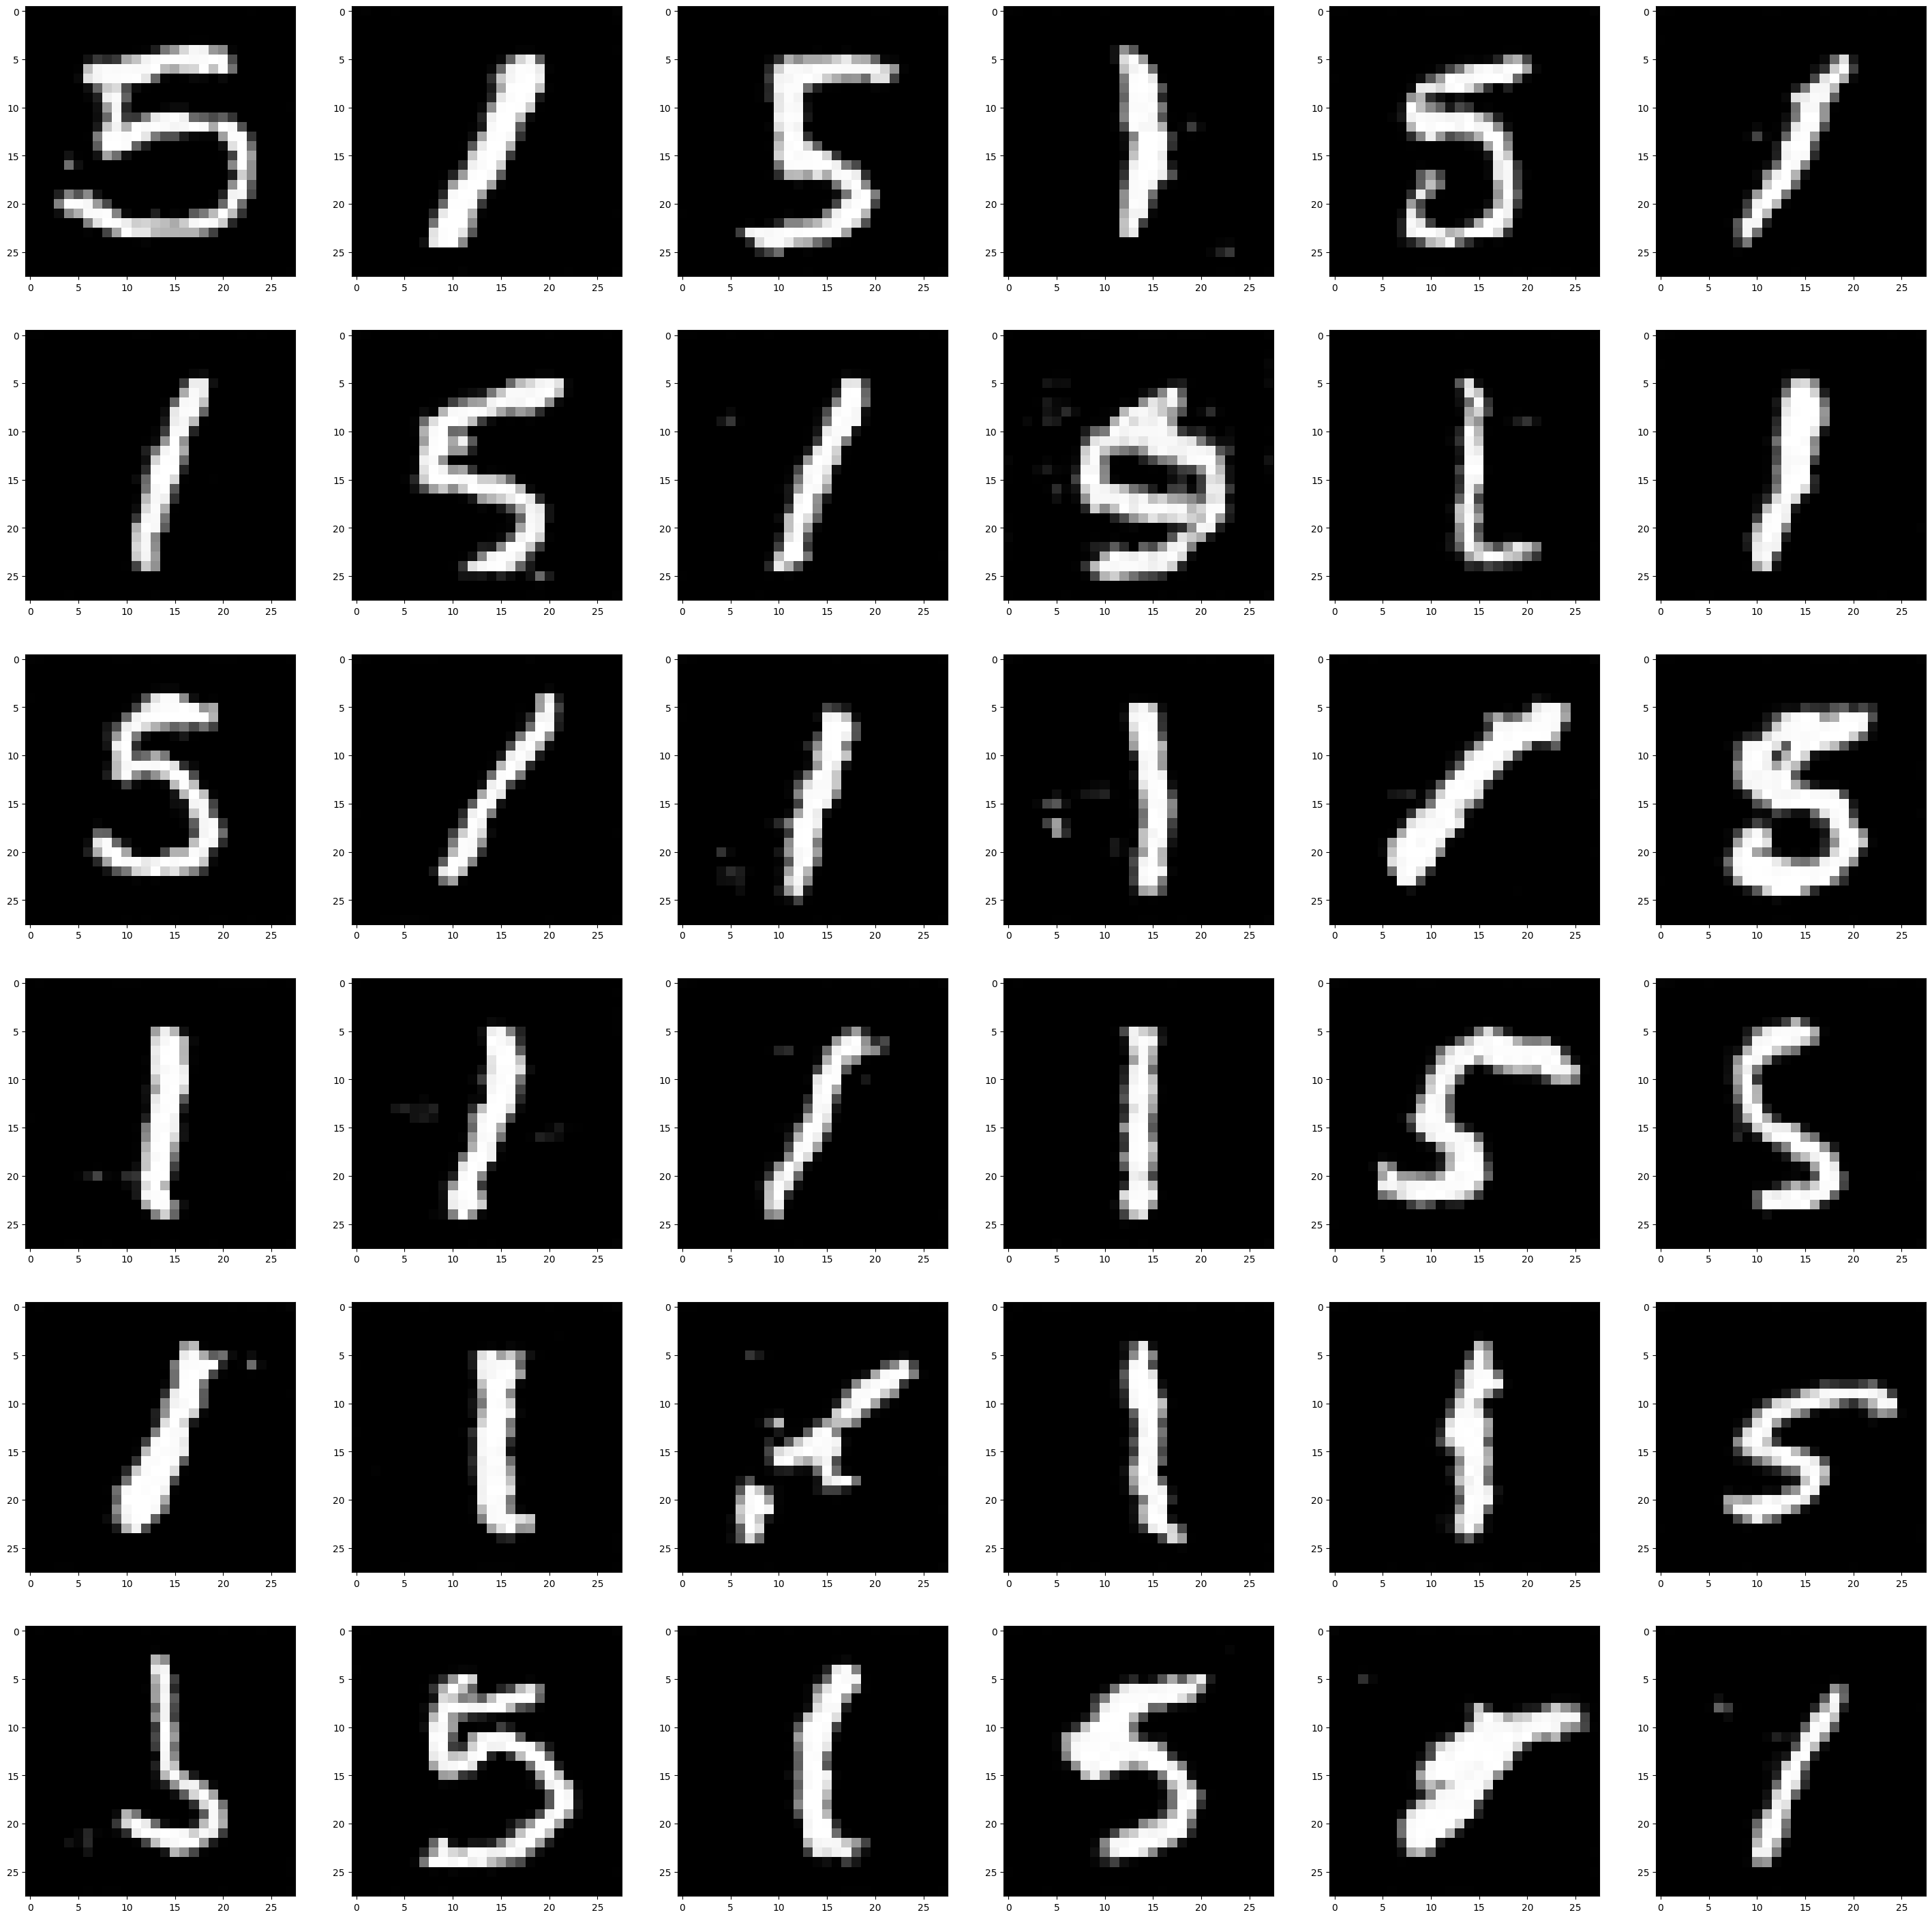

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=6, nrows=6, figsize=(36, 36))
for i in range(36):

    ax[i // 6][i % 6].imshow(s[i][0].cpu(), cmap='gray', interpolation='nearest')
plt.savefig("./learned_diffusion_ones.pdf")
plt.show()


## f) Diffusion Visualization
Here you will need to implement a plotting function that visualizes noise turning into a clean sample. Do not forget to label each image with its corresponding denoising step.

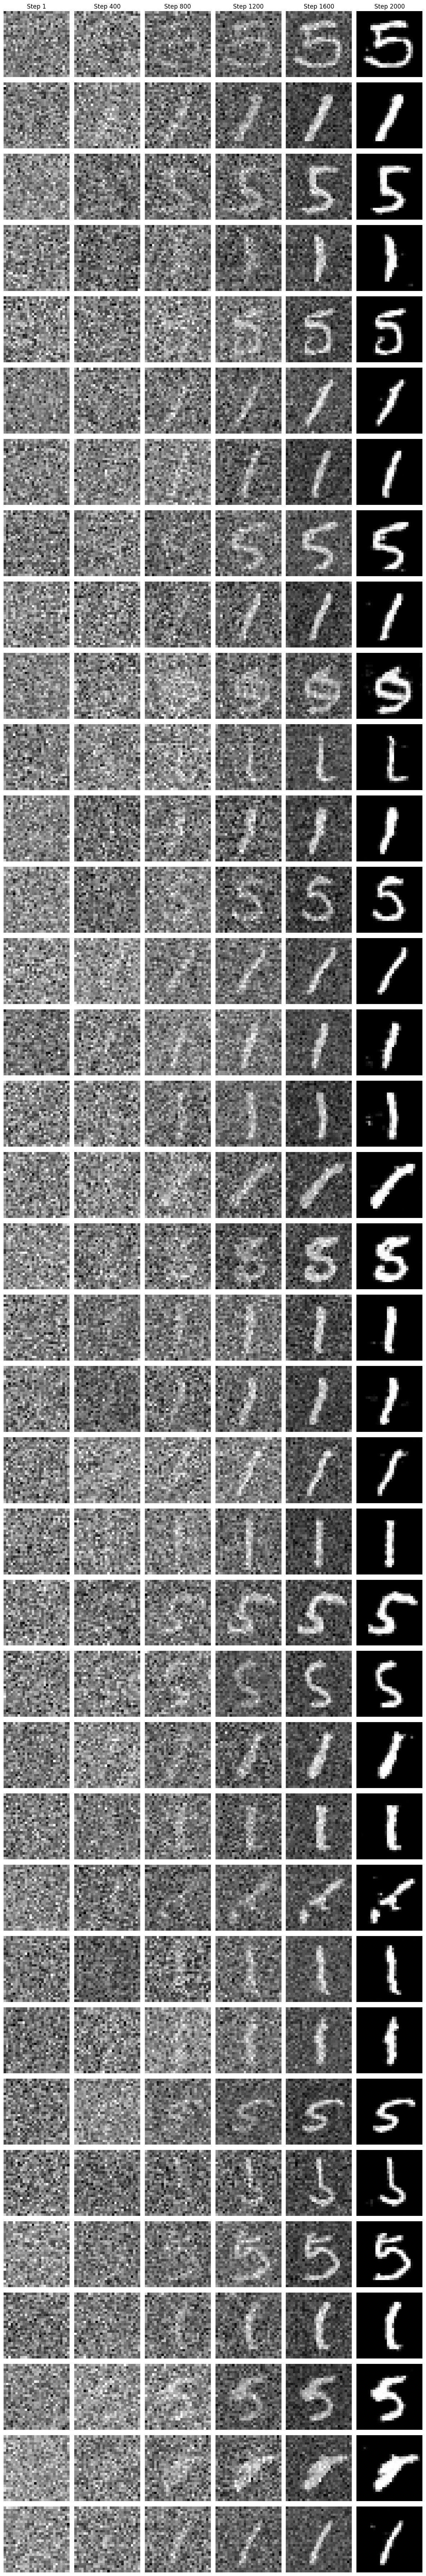

In [7]:
import matplotlib.pyplot as plt

# Number of timesteps to display
num_steps_to_display = 6

# Number of images
num_images = 36

fig, axes = plt.subplots(num_images, num_steps_to_display, figsize=(12, 72))

# Specific steps to display
steps_to_display = [0, 399, 799, 1199, 1599, 1999]

for i in range(num_images):
    for j, step in enumerate(steps_to_display):
        img = samples[step][i][0].cpu().numpy()
        ax = axes[i, j]
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if i == 0:
            ax.set_title(f'Step {step+1}')

plt.tight_layout()
plt.show()


In [8]:
!zip -r results.zip results


  adding: results/ (stored 0%)
  adding: results/steps_00006040.pt (deflated 10%)
  adding: results/steps_00006840.pt (deflated 10%)
  adding: results/steps_00005240.png (deflated 5%)
  adding: results/steps_00004440.png (deflated 3%)
  adding: results/steps_00000040.pt (deflated 12%)
  adding: results/steps_00007640.png (deflated 4%)
  adding: results/steps_00001640.pt (deflated 11%)
  adding: results/steps_00003640.pt (deflated 11%)
  adding: results/steps_00007240.pt (deflated 10%)
  adding: results/steps_00002040.pt (deflated 11%)
  adding: results/steps_00008000.png (deflated 3%)
  adding: results/steps_00004040.png (deflated 3%)
  adding: results/steps_00002440.png (deflated 5%)
  adding: results/steps_00000840.png (deflated 3%)
  adding: results/steps_00004840.pt (deflated 11%)
  adding: results/steps_00001640.png (deflated 2%)
  adding: results/steps_00004040.pt (deflated 11%)
  adding: results/steps_00003640.png (deflated 2%)
  adding: results/steps_00006040.png (deflated 3%)
